# GLIMPSE2 imputation accuracy wrt local ancestries

We downloaded GLIMPSE2's imputed result directly from Toni and Lerato at
+ `gs://paisa-bge-imputed-regional/glimpse2/merged`

The data has already been subsetted to only samples with GSA array data.

In [1]:
include("/u/home/b/biona001/bge_analysis/concordance/scripts/utilities.jl")
include("/u/home/b/biona001/bge_analysis/concordance/scripts/plots.jl")

global ancestry_aggregate_R2_exe = "/u/home/b/biona001/bge_analysis/concordance/scripts/local_ancestry_r2.jl"
global ancestry_concordance_exe = "/u/home/b/biona001/bge_analysis/concordance/scripts/local_ancestry_concordance.jl"
global ancestry_r2_exe = "/u/home/b/biona001/bge_analysis/concordance/scripts/local_ancestry_r2.jl"
global concordance_exe = "/u/home/b/biona001/bge_analysis/concordance/scripts/concordance.jl"
global aggregate_r2_exe = "/u/home/b/biona001/bge_analysis/concordance/scripts/aggregate_r2.jl"
global bcftools_exe = "/u/home/b/biona001/bcftools-1.17/bcftools"

global EUR_color = "mediumblue"
global AMR_color = "gold"
global AFR_color = "red"
global EUR_AMR_color = "green"
global EUR_AFR_color = "purple"
global AMR_AFR_color = "orange"

# helper function to submit 1 job to run a given command
function submit(command::String, ncores::Int, total_mem::Number; jobname="submit", waitfor=String[])
    mem = round(Int, total_mem / ncores) # memory per core
    filename = joinpath("/u/scratch/b/biona001", "$jobname.sh")
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#\$ -cwd")
        println(io, "# error = Merged with joblog")
        println(io, "#\$ -o /u/home/b/biona001/project-loes/joblogs/joblog.\$JOB_ID")
        println(io, "#\$ -j y")
        println(io, "#\$ -l h_rt=24:00:00,h_data=$(mem)G,arch=intel*")
        println(io, "#\$ -pe shared $ncores")
        println(io, "# Email address to notify")
        println(io, "## \$ -M \$USER@mal")
        println(io, "# Notify when:")
        println(io, "#\$ -m bea")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, ". /u/local/Modules/default/init/modules.sh")
        println(io, "module load plink")
        println(io, "module load vcftools")
        println(io, "module load julia/1.9")
        println(io, "")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job
    if length(waitfor) != 0
        run(`qsub -hold_jid $(join(waitfor, ',')) -N $jobname $filename`)
    else
        run(`qsub -N $jobname $filename`)
    end
    rm(filename, force=true)
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, total_mem::Number; jobname="submit", waitfor=String[])
    mem = round(Int, total_mem / ncores) # memory per core
    filename = joinpath("/u/scratch/b/biona001", "$jobname.sh")
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#\$ -cwd")
        println(io, "# error = Merged with joblog")
        println(io, "#\$ -o /u/home/b/biona001/project-loes/joblogs/joblog.\$JOB_ID")
        println(io, "#\$ -j y")
        println(io, "#\$ -l h_rt=24:00:00,h_data=$(mem)G,arch=intel*")
        println(io, "#\$ -pe shared $ncores")
        println(io, "# Email address to notify")
        println(io, "## \$ -M \$USER@mal")
        println(io, "# Notify when:")
        println(io, "#\$ -m bea")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, ". /u/local/Modules/default/init/modules.sh")
        println(io, "module load plink")
        println(io, "module load vcftools")
        println(io, "module load julia/1.9")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job
    if length(waitfor) != 0
        run(`qsub -hold_jid $(join(waitfor, ',')) -N $jobname $filename`)
    else
        run(`qsub -N $jobname $filename`)
    end
    rm(filename, force=true)
end

submit (generic function with 2 methods)

## Filter imputed result to genotyped SNPs

In [16]:
using SnpArrays

data_dir = "/u/home/b/biona001/project-loes/GLIMPSE2_toni"
out_dir = "/u/home/b/biona001/project-loes/GLIMPSE2_toni/typedSNPs"
plink = SnpData("/u/home/b/biona001/project-loes/ForBen_genotypes_subset/DataV1_QC_hg38")

for chr in 1:22
    # file names
    imputed_file = joinpath(data_dir, "paisa_gsa_merged_chr$chr.vcf.gz")
    outfile = joinpath(out_dir, "chr$chr.vcf.gz")
    keep_pos_file = joinpath(out_dir, "chr$chr.keep.pos")

    # compute SNPs to keep
    typed_snps = plink.snp_info[findall(x -> x == string(chr), plink.snp_info[!, "chromosome"]), "position"]
    writedlm(keep_pos_file, [["chr$chr" for _ in 1:length(typed_snps)] typed_snps])

    # filter
    cmd1 = "$bcftools_exe view -T $keep_pos_file $imputed_file -Oz -o $outfile"
    cmd2 = "$bcftools_exe index $outfile"
    submit([cmd1, cmd2], 1, 8, jobname="filter$chr")
end

Your job 1444633 ("filter1") has been submitted
Your job 1444634 ("filter2") has been submitted
Your job 1444635 ("filter3") has been submitted
Your job 1444636 ("filter4") has been submitted
Your job 1444637 ("filter5") has been submitted
Your job 1444638 ("filter6") has been submitted
Your job 1444639 ("filter7") has been submitted
Your job 1444640 ("filter8") has been submitted
Your job 1444641 ("filter9") has been submitted
Your job 1444642 ("filter10") has been submitted
Your job 1444643 ("filter11") has been submitted
Your job 1444644 ("filter12") has been submitted
Your job 1444645 ("filter13") has been submitted
Your job 1444646 ("filter14") has been submitted
Your job 1444647 ("filter15") has been submitted
Your job 1444648 ("filter16") has been submitted
Your job 1444649 ("filter17") has been submitted
Your job 1444650 ("filter18") has been submitted
Your job 1444651 ("filter19") has been submitted
Your job 1444652 ("filter20") has been submitted
Your job 1444653 ("filter21")

## Concordance by local ancestry (no chibchan, remove non-pure AMR)

Note: "snpQC" in imputed data refers to those SNPs passing QC in array genotypes. There's currently no INFO score filtering.

In [7]:
geno_dir = "/u/home/b/biona001/project-loes/ForBen_genotypes_subset/QC_hg38_conformed_king"
msp_dir = "/u/home/b/biona001/project-loes/ForBen_genotypes_subset/LAI/output_v2"
glimpse2_dir = "/u/home/b/biona001/project-loes/GLIMPSE2_toni/typedSNPs"
out_dir = "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy"

for chr in 1:22
    genotype_file = joinpath(geno_dir, "chr$chr.vcf.gz")
    imputed_file = joinpath(glimpse2_dir, "chr$chr.sampleQC.snpQC.vcf.gz") # snpQC = pass array QC, no QC for imputed data yet
    msp_file = joinpath(msp_dir, "chr$chr.msp.tsv")
    outfile = joinpath(out_dir, "chr$chr.concordance")
    cmd = "julia $ancestry_concordance_exe --truth $genotype_file --impt $imputed_file --msp $msp_file --out $outfile"
    submit(cmd, 1, 12, jobname="chr$(chr)conc", waitfor=["filter$chr"])
end

Your job 1562565 ("chr1conc") has been submitted
Your job 1562566 ("chr2conc") has been submitted
Your job 1562567 ("chr3conc") has been submitted
Your job 1562568 ("chr4conc") has been submitted
Your job 1562570 ("chr5conc") has been submitted
Your job 1562571 ("chr6conc") has been submitted
Your job 1562572 ("chr7conc") has been submitted
Your job 1562574 ("chr8conc") has been submitted
Your job 1562575 ("chr9conc") has been submitted
Your job 1562576 ("chr10conc") has been submitted
Your job 1562577 ("chr11conc") has been submitted
Your job 1562578 ("chr12conc") has been submitted
Your job 1562579 ("chr13conc") has been submitted
Your job 1562580 ("chr14conc") has been submitted
Your job 1562581 ("chr15conc") has been submitted
Your job 1562582 ("chr16conc") has been submitted
Your job 1562583 ("chr17conc") has been submitted
Your job 1562584 ("chr18conc") has been submitted
Your job 1562585 ("chr19conc") has been submitted
Your job 1562586 ("chr20conc") has been submitted
Your job 

## Make plot (non-ref concordance)

MAF ∈ (0.0, 0.005050505050505051) have 36050 SNPs
MAF ∈ (0.005050505050505051, 0.010101010101010102) have 26599 SNPs
MAF ∈ (0.010101010101010102, 0.015151515151515152) have 25735 SNPs
MAF ∈ (0.015151515151515152, 0.020202020202020204) have 19390 SNPs
MAF ∈ (0.020202020202020204, 0.025252525252525252) have 17408 SNPs
MAF ∈ (0.025252525252525252, 0.030303030303030304) have 12291 SNPs
MAF ∈ (0.030303030303030304, 0.03535353535353535) have 9824 SNPs
MAF ∈ (0.03535353535353535, 0.04040404040404041) have 8512 SNPs
MAF ∈ (0.04040404040404041, 0.045454545454545456) have 6283 SNPs
MAF ∈ (0.045454545454545456, 0.050505050505050504) have 5981 SNPs
MAF ∈ (0.050505050505050504, 0.05555555555555555) have 4566 SNPs
MAF ∈ (0.05555555555555555, 0.06060606060606061) have 4024 SNPs
MAF ∈ (0.06060606060606061, 0.06565656565656566) have 4019 SNPs
MAF ∈ (0.06565656565656566, 0.0707070707070707) have 3345 SNPs
MAF ∈ (0.0707070707070707, 0.07575757575757576) have 3533 SNPs
MAF ∈ (0.07575757575757576, 0.080808

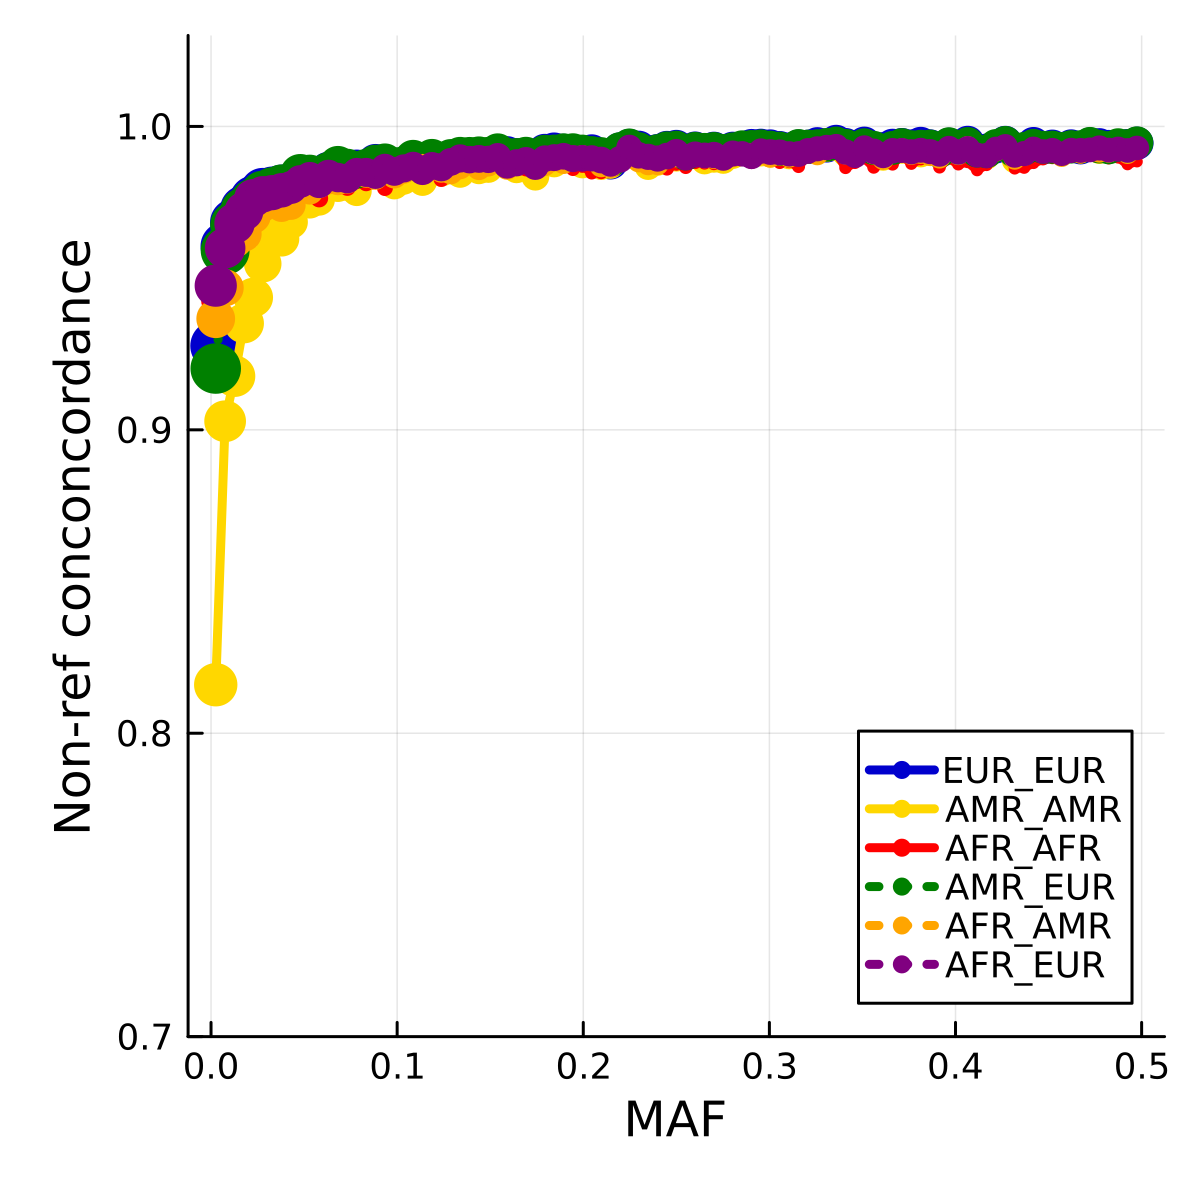

In [41]:
ancestries = ["EUR_EUR", "AMR_AMR", "AFR_AFR", "AMR_EUR", "AFR_AMR", "AFR_EUR"]
maf_bins = collect(LinRange(0, 0.5, 100))
# maf_bins = vcat(0.0, 0.001, collect(0.01:0.01:0.5))

# concordances (one vector for each ancestry background)
concordances = [Float64[] for _ in eachindex(ancestries)]
mafs = [Float64[] for _ in eachindex(ancestries)]
ngenotypes = [Int[] for _ in eachindex(ancestries)]
for chr in 1:22
    (chr == 10) && continue
    outfiles = [
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceEUR_EUR",
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAMR_AMR",
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAFR_AFR",
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAMR_EUR",
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAFR_AMR",
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAFR_EUR",
    ]
    for (j, outfile) in enumerate(outfiles)
        df = CSV.read(outfile, DataFrame)
        append!(concordances[j], df[!, "nonref_concordances"])
        append!(mafs[j], df[!, "MAF"])
        append!(ngenotypes[j], df[!, "ngenotypes"])
    end
end

# compute bin sizes for each ancestry
# bin_sizes = [
#     compute_bin_sizes(mafs[j], ngenotypes[j], maf_bins, offset=17) for j in eachindex(ancestries)
# ]
tot_snps = readdlm("/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/allchr.aggregate.r2tot_snps")
bin_sizes = log.(tot_snps) .- 7
bin_sizes = [bin_sizes[:, 1], bin_sizes[:, 4], bin_sizes[:, 5], bin_sizes[:, 3], bin_sizes[:, 6], bin_sizes[:, 2]] # order of ancestry is in allchr.aggregate.r2 

# make plot
title = ""
my_colors = [EUR_color, AMR_color, AFR_color, EUR_AMR_color, AMR_AFR_color, EUR_AFR_color]
my_series_style = [:solid, :solid, :solid, :dot, :dot, :dot]
plt3 = make_concordance_plots(
    concordances, mafs, ancestries, maf_bins, title, 
    markersizes=bin_sizes, ymin=0.7, ymax=1.03,
    my_colors=my_colors, my_series_style=my_series_style
)
# annotate!(plt3, -0.13002, 0.82, Plots.text("(AMR > 90%)", :black, rotation = 90, 16))
# plot(plt3, left_margin=10Plots.mm)
plt3 = plot(plt3, left_margin=2Plots.mm)

MAF ∈ (0.0, 0.005050505050505051) have 36050 SNPs
MAF ∈ (0.005050505050505051, 0.010101010101010102) have 26599 SNPs
MAF ∈ (0.010101010101010102, 0.015151515151515152) have 25735 SNPs
MAF ∈ (0.015151515151515152, 0.020202020202020204) have 19390 SNPs
MAF ∈ (0.020202020202020204, 0.025252525252525252) have 17408 SNPs
MAF ∈ (0.025252525252525252, 0.030303030303030304) have 12291 SNPs
MAF ∈ (0.030303030303030304, 0.03535353535353535) have 9824 SNPs
MAF ∈ (0.03535353535353535, 0.04040404040404041) have 8512 SNPs
MAF ∈ (0.04040404040404041, 0.045454545454545456) have 6283 SNPs
MAF ∈ (0.045454545454545456, 0.050505050505050504) have 5981 SNPs
MAF ∈ (0.050505050505050504, 0.05555555555555555) have 4566 SNPs
MAF ∈ (0.05555555555555555, 0.06060606060606061) have 4024 SNPs
MAF ∈ (0.06060606060606061, 0.06565656565656566) have 4019 SNPs
MAF ∈ (0.06565656565656566, 0.0707070707070707) have 3345 SNPs
MAF ∈ (0.0707070707070707, 0.07575757575757576) have 3533 SNPs
MAF ∈ (0.07575757575757576, 0.080808

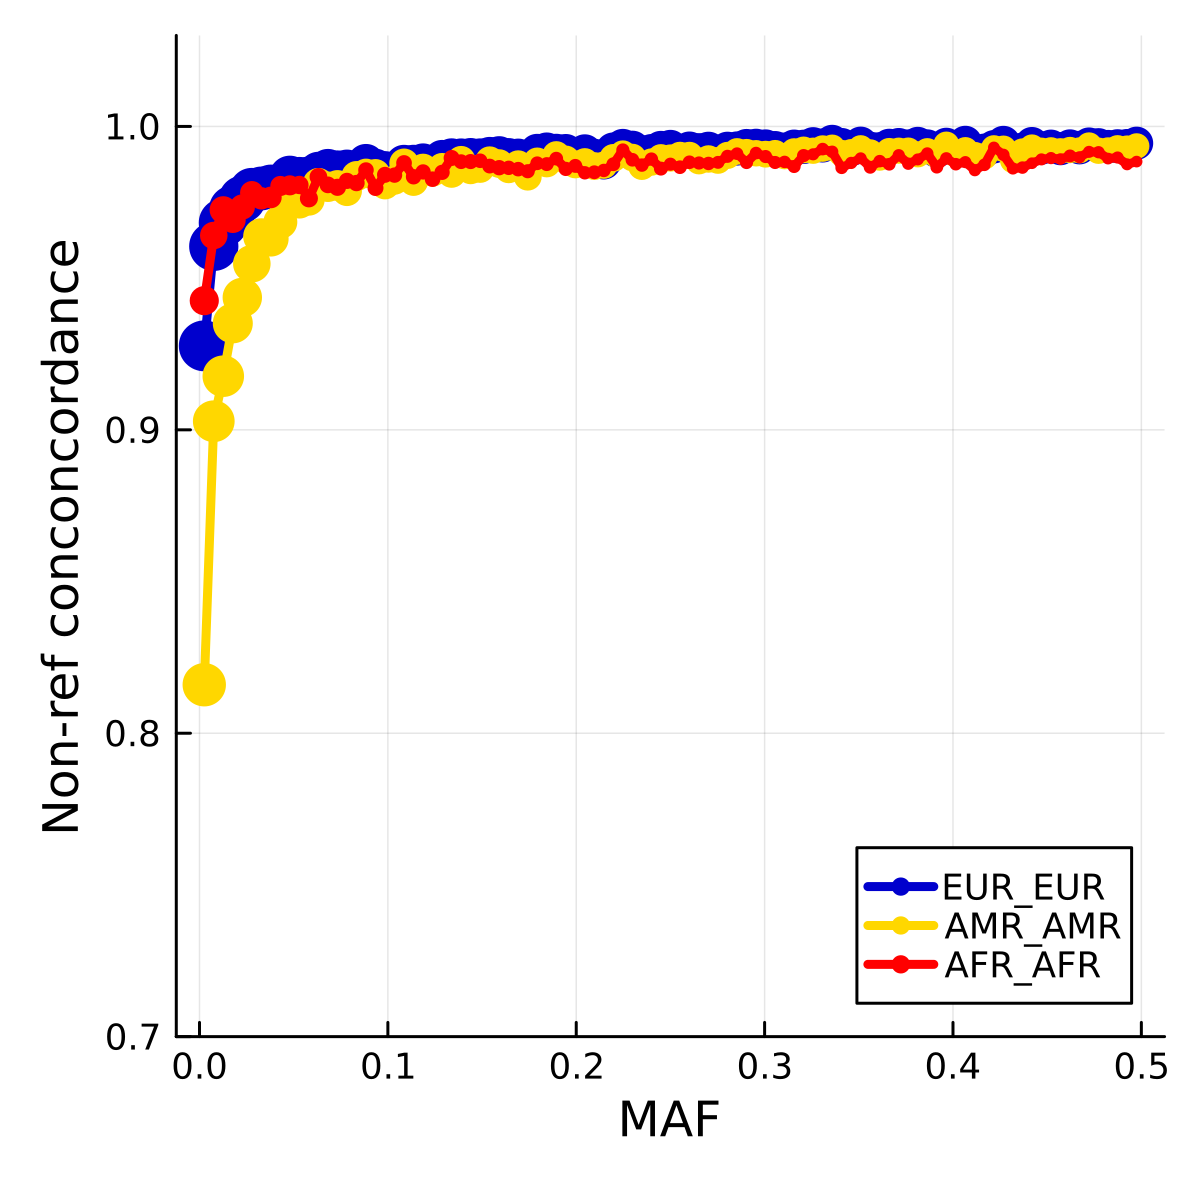

In [42]:
ancestries = ["EUR_EUR", "AMR_AMR", "AFR_AFR"]
maf_bins = collect(LinRange(0, 0.5, 100))
# maf_bins = vcat(0.0, 0.001, collect(0.01:0.01:0.5))

# concordances (one vector for each ancestry background)
concordances = [Float64[] for _ in eachindex(ancestries)]
mafs = [Float64[] for _ in eachindex(ancestries)]
ngenotypes = [Int[] for _ in eachindex(ancestries)]
for chr in 1:22
    (chr == 10) && continue
    outfiles = [
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceEUR_EUR",
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAMR_AMR",
        "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAFR_AFR",
#         "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAMR_EUR",
#         "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAFR_AMR",
#         "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/chr$chr.concordanceAFR_EUR",
    ]
    for (j, outfile) in enumerate(outfiles)
        df = CSV.read(outfile, DataFrame)
        append!(concordances[j], df[!, "nonref_concordances"])
        append!(mafs[j], df[!, "MAF"])
        append!(ngenotypes[j], df[!, "ngenotypes"])
    end
end

# compute bin sizes for each ancestry
# bin_sizes = [
#     compute_bin_sizes(mafs[j], ngenotypes[j], maf_bins, offset=17) for j in eachindex(ancestries)
# ]
tot_snps = readdlm("/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/allchr.aggregate.r2tot_snps")
bin_sizes = log.(tot_snps) .- 7
bin_sizes = [bin_sizes[:, 1], bin_sizes[:, 4], bin_sizes[:, 5], bin_sizes[:, 3], bin_sizes[:, 6], bin_sizes[:, 2]] # order of ancestry is in allchr.aggregate.r2 

# make plot
title = ""
my_colors = [EUR_color, AMR_color, AFR_color]
my_series_style = [:solid, :solid, :solid]
plt3_sub = make_concordance_plots(
    concordances, mafs, ancestries, maf_bins, title, 
    markersizes=bin_sizes, ymin=0.7, ymax=1.03,
    my_colors=my_colors, my_series_style=my_series_style, 
)
# annotate!(plt3, -0.13002, 0.82, Plots.text("(AMR > 90%)", :black, rotation = 90, 16))
# plot(plt3, left_margin=10Plots.mm)
plt3_sub = plot(plt3_sub)

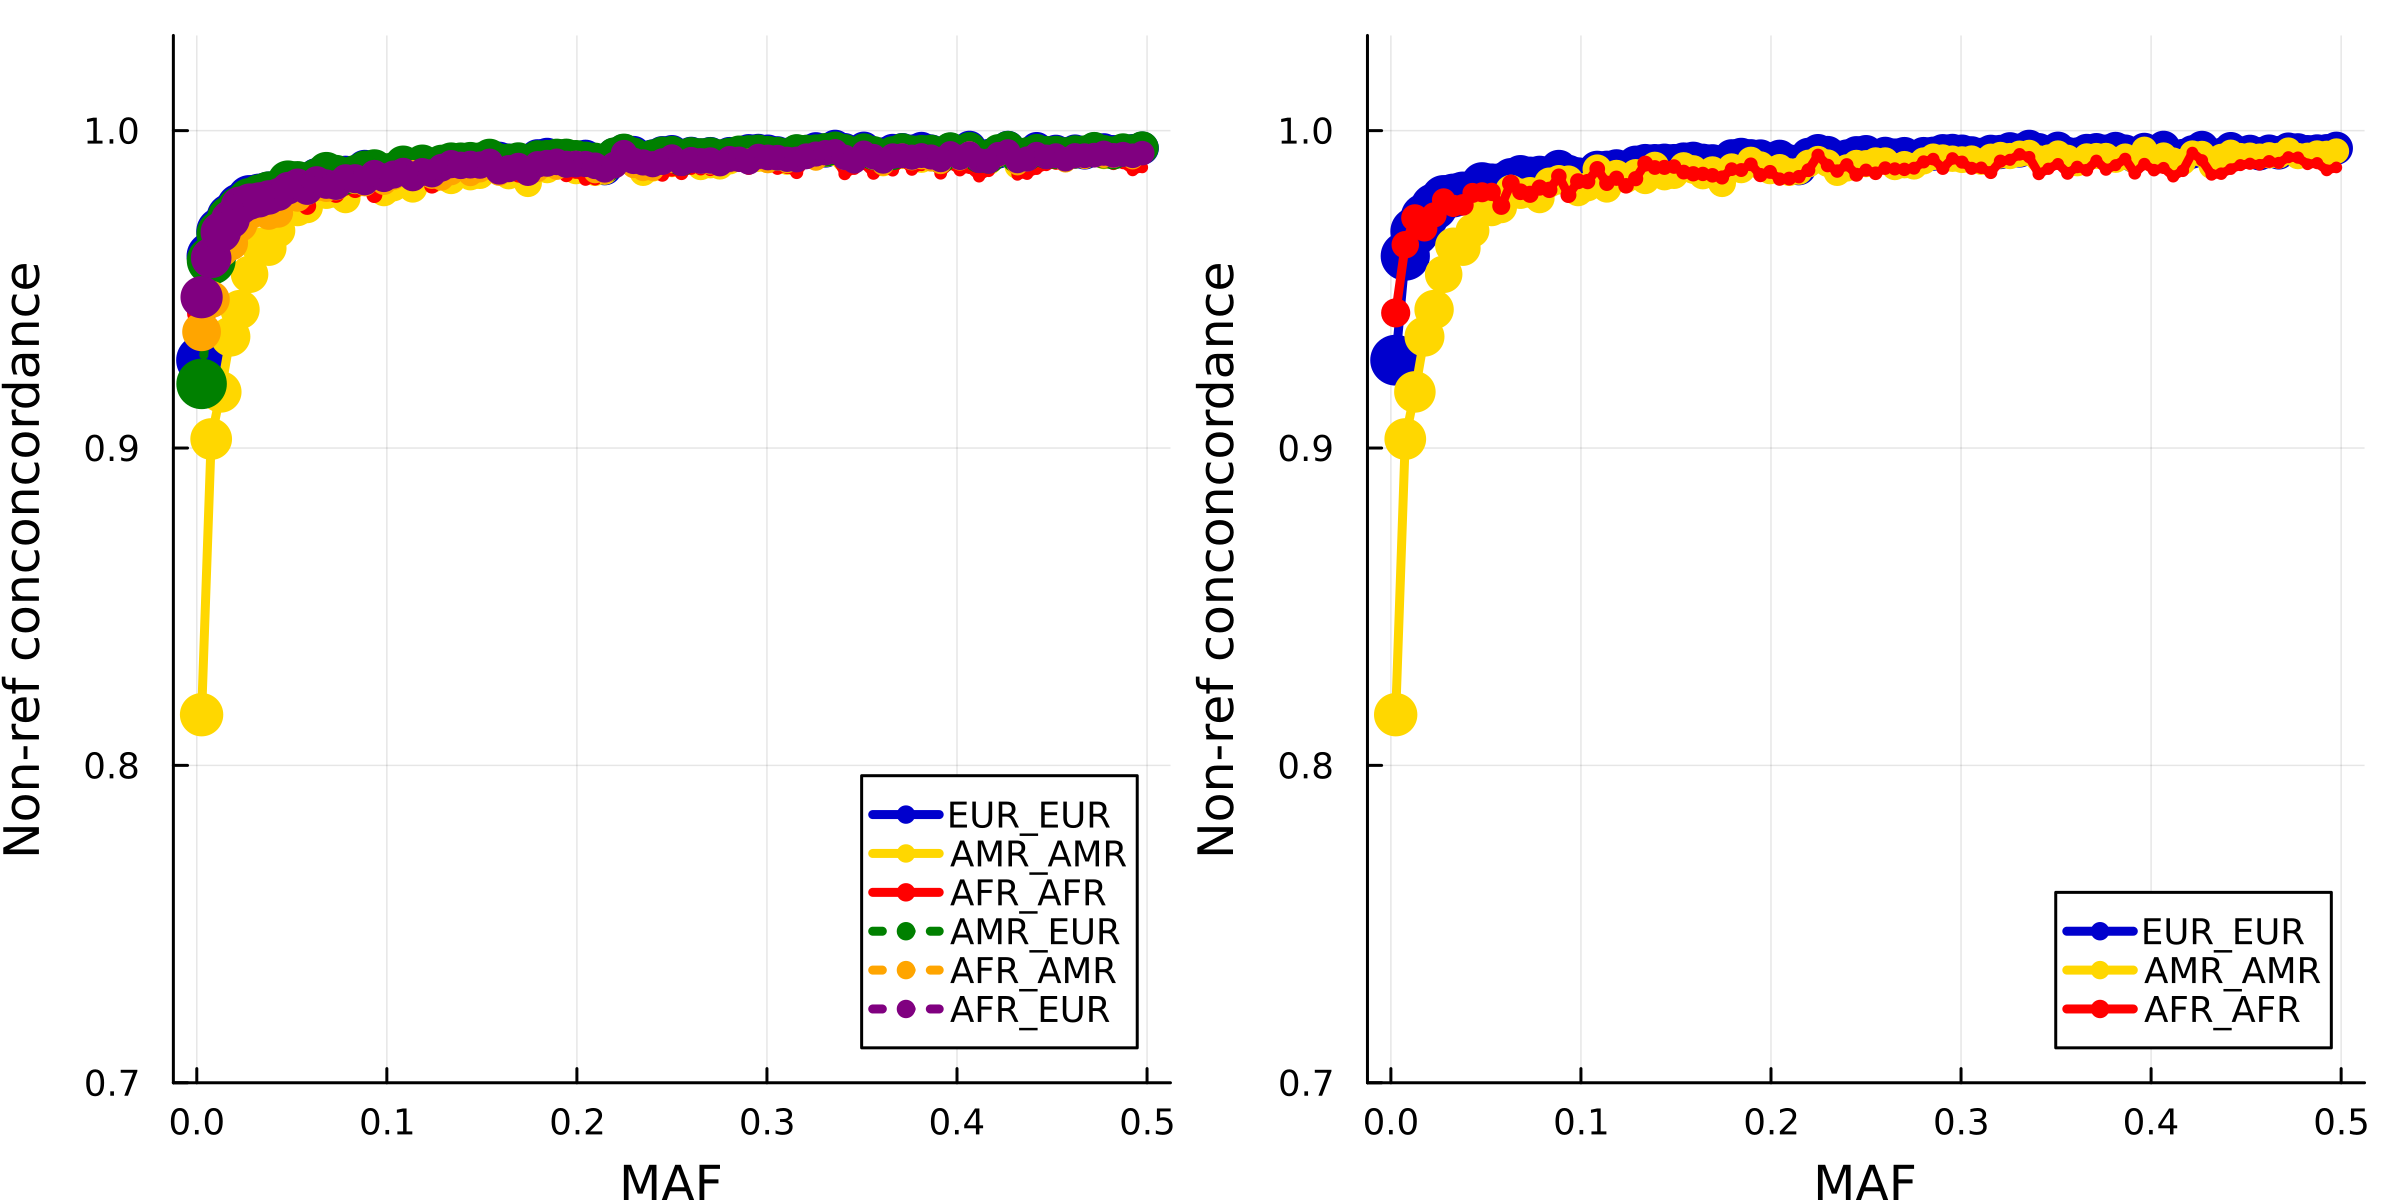

In [43]:
# Combine
plot(plt3, plt3_sub, size=(800, 400))

# Aggregate R2 by local ancestry (no chibchan, remove non-pure AMR)


In [2]:
geno_dir = "/u/home/b/biona001/project-loes/ForBen_genotypes_subset/QC_hg38_conformed_king"
msp_dir = "/u/home/b/biona001/project-loes/ForBen_genotypes_subset/LAI/output_v2"
glimpse2_dir = "/u/home/b/biona001/project-loes/GLIMPSE2_toni/typedSNPs"
out_dir = "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy"
maf_bins = collect(LinRange(0, 0.5, 100))

genotype_files = String[]
imputed_files = String[]
msp_files = String[]
for chr in 1:22
    (chr == 10) && continue
    push!(genotype_files, joinpath(geno_dir, "chr$chr.vcf.gz"))
    push!(imputed_files, joinpath(glimpse2_dir, "chr$chr.sampleQC.snpQC.vcf.gz")) # snpQC = pass array QC, no QC for imputed data yet
    push!(msp_files, joinpath(msp_dir, "chr$chr.msp.tsv"))
end
genofile = "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/genotype_files.txt"
imptfile = "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/imputed_files.txt"
mspfile = "/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/msp_files.txt"
writedlm(genofile, genotype_files)
writedlm(imptfile, imputed_files)
writedlm(mspfile, msp_files)
outfile = joinpath(out_dir, "allchr.aggregate.r2")
cmd = "julia $ancestry_aggregate_R2_exe --truth $genofile --impt $imptfile --msp $mspfile --out $outfile --maf-bins $(join(maf_bins, ','))"
submit(cmd, 1, 24, jobname="r2")

Your job 1577746 ("r2") has been submitted


## Make plot

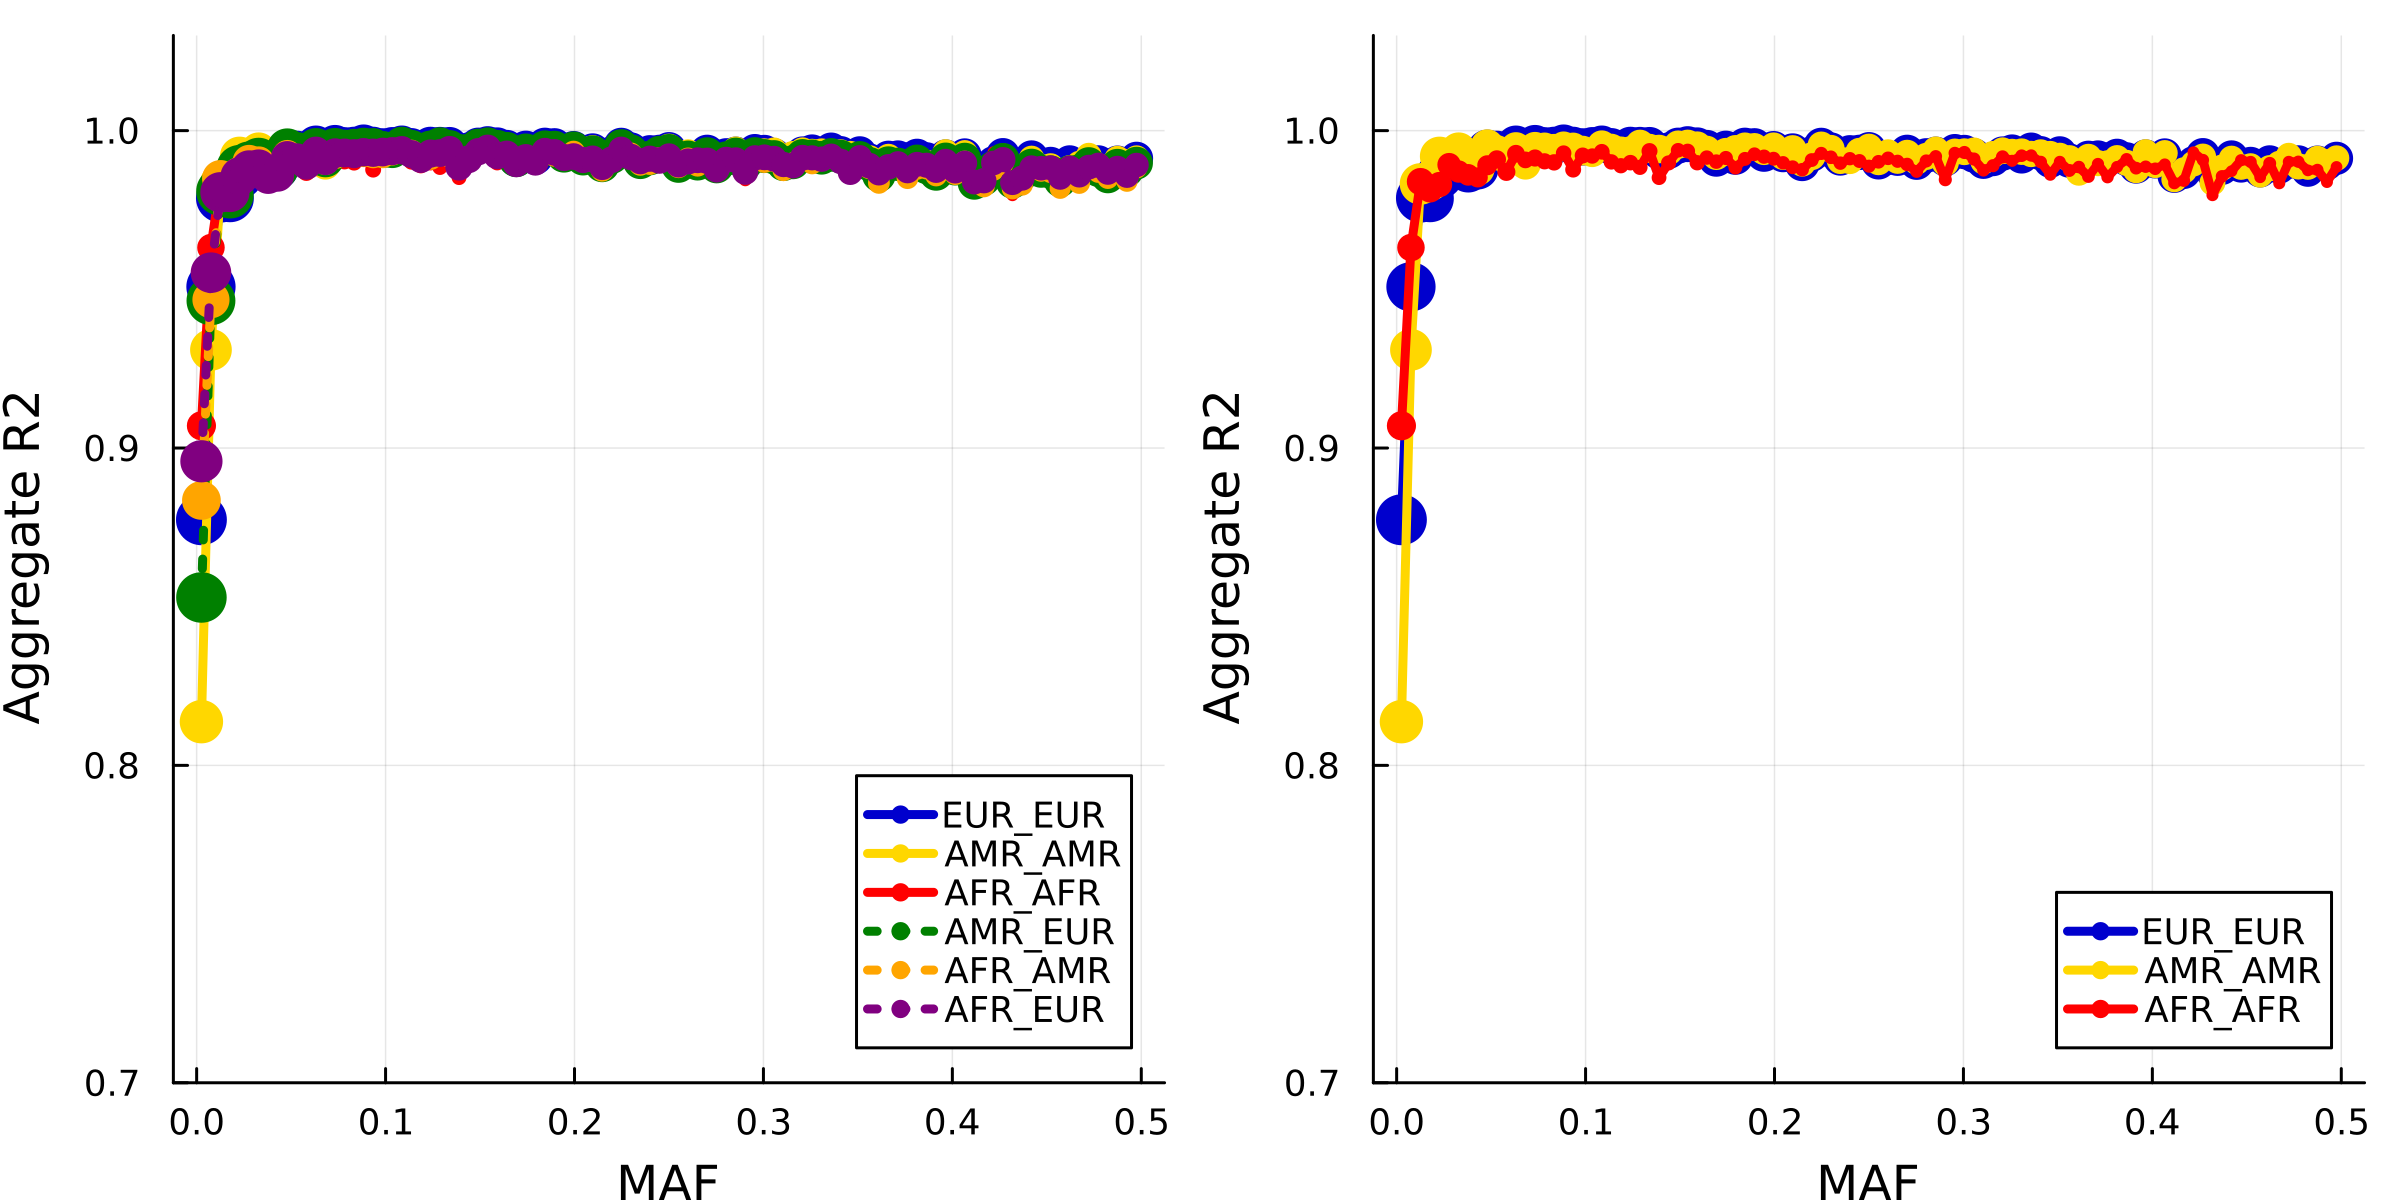

In [40]:
include("/u/home/b/biona001/bge_analysis/concordance/scripts/plots.jl")

#
# all ancestries
#
ancestries = ["EUR_EUR", "AMR_AMR", "AFR_AFR", "AMR_EUR", "AFR_AMR", "AFR_EUR"]
maf_bins = collect(LinRange(0, 0.5, 100))
df = CSV.read("/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/allchr.aggregate.r2", DataFrame)
tot_snps = readdlm("/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/allchr.aggregate.r2tot_snps")
bin_sizes = log.(tot_snps) .- 7
bin_sizes = [bin_sizes[:, 1], bin_sizes[:, 4], bin_sizes[:, 5], bin_sizes[:, 3], bin_sizes[:, 6], bin_sizes[:, 2]] # order of ancestry is in allchr.aggregate.r2 

# make plot
title = ""
my_colors = [EUR_color, AMR_color, AFR_color, EUR_AMR_color, AMR_AFR_color, EUR_AFR_color]
my_series_style = [:solid, :solid, :solid, :dot, :dot, :dot]
aggregate_R2s = [df[!, ancestry] for ancestry in ancestries]
plt1 = make_aggregate_R2_plots(
    aggregate_R2s, ancestries, maf_bins, title, 
    ymin=0.7, ymax=1.03, my_color=my_colors, my_series_style=my_series_style, 
    markersize=bin_sizes
)
plt1 = plot(plt1, left_margin=2Plots.mm)



#
# remove mixed ancestries
#
ancestries = ["EUR_EUR", "AMR_AMR", "AFR_AFR"]
maf_bins = collect(LinRange(0, 0.5, 100))
df = CSV.read("/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/allchr.aggregate.r2", DataFrame)
tot_snps = readdlm("/u/home/b/biona001/project-loes/GLIMPSE2_toni/accuracy/allchr.aggregate.r2tot_snps")
bin_sizes = log.(tot_snps) .- 7
bin_sizes = [bin_sizes[:, 1], bin_sizes[:, 4], bin_sizes[:, 5]]

# make plot
title = ""
my_colors = [EUR_color, AMR_color, AFR_color]
my_series_style = [:solid, :solid, :solid]
aggregate_R2s = [df[!, ancestry] for ancestry in ancestries]
plt2 = make_aggregate_R2_plots(
    aggregate_R2s, ancestries, maf_bins, title, 
    ymin=0.7, ymax=1.03, my_color=my_colors, my_series_style=my_series_style, 
    markersize=bin_sizes
)
plt2 = plot(plt2, left_margin=2Plots.mm)

#
# combine
#
plot(plt1, plt2, size=(800, 400))